In [68]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image
import io
import random

# import the label map utility module
from object_detection.utils import label_map_util
# import module for reading and updating configuration files.
from object_detection.utils import config_util
# import module for visualization. use the alias `viz_utils`
from object_detection.utils import visualization_utils as viz_utils
# import module for building the detection model
from object_detection.builders import model_builder

In [ ]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [64]:
recordfile = r"E:\Kuliah\Bangkit\Capstone\Dataset\DatasetTFRecord\Cirebon.tfrecord"
raw_dataset = tf.data.TFRecordDataset(recordfile)
raw_dataset
for raw_record in raw_dataset.take(1):
#   print(repr(raw_record)) #output masih binary encoded
    pass

# https://stackoverflow.com/questions/51409906/converting-tfrecords-back-into-jpeg-images
image_feature_description = {
    'image/height': tf.io.FixedLenFeature([], dtype=tf.int64),
    'image/width': tf.io.FixedLenFeature([], dtype=tf.int64),
    'image/filename': tf.io.FixedLenFeature([], dtype=tf.string),
    'image/source_id': tf.io.FixedLenFeature([], tf.string),
    'image/encoded': tf.io.FixedLenFeature([], dtype=tf.string),
    'image/format': tf.io.FixedLenFeature([], dtype=tf.string),
    'image/object/bbox/xmin': tf.io.FixedLenFeature([], tf.float32),
    'image/object/bbox/xmax': tf.io.FixedLenFeature([], tf.float32),
    'image/object/bbox/ymin': tf.io.FixedLenFeature([], tf.float32),
    'image/object/bbox/ymax': tf.io.FixedLenFeature([], tf.float32),
    'image/object/class/text': tf.io.FixedLenFeature([], tf.float32),
    'image/object/class/label': tf.io.FixedLenFeature([], dtype=tf.int64),
}

# https://medium.com/@moritzkrger/speeding-up-keras-with-tfrecord-datasets-5464f9836c36
# Transform parsed_dataset as input to model.fit
# https://stackoverflow.com/questions/60601412/tensorflow-2-0-how-to-transform-from-mapdataset-after-reading-from-tfrecord-t
def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

def _parse_image_sequences_function(example_proto):
    return tf.io.parse_sequence_example(example_proto, image_feature_description)

parsed_image_dataset = raw_dataset.map(_parse_image_function)
# print(parsed_image_dataset)

parsed_image_dataset_sequence = raw_dataset.map(_parse_image_sequences_function)
# print(parsed_image_dataset_sequence)



In [61]:
# parsed_image_dataset

# <MapDataset shapes: 
#     {image/encoded: (), 
#      image/filename: (), 
#      image/format: (), 
#      image/height: (), 
#      image/object/bbox/xmax: (), 
#      image/object/bbox/xmin: (), 
#      image/object/bbox/ymax: (), 
#      image/object/bbox/ymin: (), 
#      image/object/class/label: (), 
#      image/object/class/text: (), 
#      image/source_id: (), 
#      image/width: ()}, 
#     types: 
#         {image/encoded: tf.string, 
#          image/filename: tf.string, 
#          image/format: tf.string, 
#          image/height: tf.int64, 
#          image/object/bbox/xmax: 
#          tf.float32, 
#          image/object/bbox/xmin: tf.float32, 
#          image/object/bbox/ymax: tf.float32, 
#          image/object/bbox/ymin: tf.float32, 
#          image/object/class/label: tf.int64, 
#          image/object/class/text: tf.float32, 
#          image/source_id: tf.string, 
#          image/width: tf.int64
#         }
# >

In [ ]:
# parsed_image_dataset_sequence
# <MapDataset 
#     shapes: 
#         ({image/encoded: (), 
#           image/filename: (), 
#           image/format: (), 
#           image/height: (), 
#           image/object/bbox/xmax: (), 
#           image/object/bbox/xmin: (), 
#           image/object/bbox/ymax: (), 
#           image/object/bbox/ymin: (), 
#           image/object/class/label: (), 
#           image/object/class/text: (), 
#           image/source_id: (), 
#           image/width: ()
#          }, 
#          {}, 
#          {}), 
#     types:
#         ({image/encoded: tf.string, 
#           image/filename: tf.string, 
#           image/format: tf.string, 
#           image/height: tf.int64, 
#           image/object/bbox/xmax: tf.float32, 
#           image/object/bbox/xmin: tf.float32, 
#           image/object/bbox/ymax: tf.float32, 
#           image/object/bbox/ymin: tf.float32, 
#           image/object/class/label: tf.int64, 
#           image/object/class/text: tf.float32, 
#           image/source_id: tf.string, 
#           image/width: tf.int64}, 
#          {}, 
#          {})
# >

value: 0.49468085
value: 0.5106383
value: 0.5265958
value: 0.5212766
value: 0.5319149
value: 0.5319149
value: 0.5159575



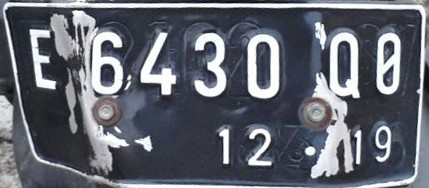

In [80]:
# Ambil isi features
tf_record_iterator = tf.compat.v1.python_io.tf_record_iterator
tfrecord_path = recordfile

features = [] #array feature masing masing image

for i, record in enumerate(tf_record_iterator(tfrecord_path)):
    example = tf.train.Example()
    example.ParseFromString(record)
    feat = example.features.feature
    features.append(feat)

key = random.randint(1,50)
filename = features[key]["image/filename"].bytes_list.value[0].decode("utf-8")
img_format = features[key]["image/format"].bytes_list.value[0].decode("utf-8")
img =  features[key]["image/encoded"].bytes_list.value[0]
xmin = features[key]["image/object/bbox/xmin"].float_list
xmax = features[key]["image/object/bbox/xmax"].float_list
ymin = features[key]["image/object/bbox/ymin"].float_list
ymax = features[key]["image/object/bbox/ymax"].float_list

label = features[key]["image/object/class/label"].int64_list 
img_buffer = io.BytesIO(img)
Image.open(img_buffer)